In [1]:
import tensorflow as tf
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import load_img


In [2]:
lt=[cv2.ROTATE_180,cv2.ROTATE_90_COUNTERCLOCKWISE,cv2.ROTATE_90_CLOCKWISE]
def brightness(img):
  value = random.uniform(0.5,2)
  hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  hsv=np.array(hsv, dtype = np.float64)
  hsv[:,:,1] = hsv[:,:,1]*value
  hsv[:,:,1][hsv[:,:,1]>255] = 255
  hsv[:,:,2] = hsv[:,:,2]*value
  hsv[:,:,2][hsv[:,:,2]>255] = 255
  hsv=np.array(hsv, dtype = np.uint8)
  img=cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  return img

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pathlib
import glob
directory=pathlib.Path("/content/drive/MyDrive/arts")

In [6]:
resultant="/content/augumentedimages"

In [7]:
items = os.listdir(directory)

classes = []
count = 0
images = []
labels = []

for i in items:
    i1 = 0
    print(i)
    classes.append(i)
    path1 = f"{directory}/{i}"
    a = random.randint(5, 10)

    while a != 0:
        img = cv2.imread(path1)
        img = cv2.resize(img, (224,224))
        k = i.split(".")[0]

        # Save the original image
        cv2.imwrite(f"{resultant}/{k}{i1}.jpeg", img)
        images.append(img)
        labels.append(count)

        img = cv2.rotate(img, lt[random.randint(0, 2)])  # Rotate the image

        # Save the rotated image
        cv2.imwrite(f"{resultant}/{k}{i1 + 1}.jpeg", img)
        images.append(img)
        labels.append(count)

        # Apply brightness adjustment (only for even rotations)
        if a % 2 == 0:
            img = brightness(img)
            # Save the brightness-adjusted image
            cv2.imwrite(f"{resultant}/{k}{i1 + 2}.jpeg", img)
            images.append(img)
            labels.append(count)

        a -= 1
        i1 += 3  # Increment by 3 for the three image variations

    count += 1

# Convert the lists to NumPy arrays
images = np.array(images, dtype=np.uint8)
labels = np.array(labels)

print(images.size)


mosaicart.jpg
3Dart.jpg
scumblingart.jpg
stipplingart.jpg
pastelart.jpg
pixelart.jpg
caricatureart.jpg
doodle.jpg
sandart.jpg
sketchart.jpg
warliart.jpg
zentangleart.jpg
36126720


In [8]:
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import*
from keras.applications.vgg19 import VGG19,preprocess_input


In [9]:
model=VGG19(weights="imagenet")
for i in model.layers:
  i.trainable=False
len(model.layers)


574710816/574710816 [==============================] - 4s 0us/step


26

In [10]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
transferVGG=Sequential()
for i in range(18):
  transferVGG.add(model.layers[i])
transferVGG.add(Flatten())
transferVGG.add(Dense(512,activation="relu"))
transferVGG.add(Dense(218,activation="relu"))
transferVGG.add(Dense(13,activation="softmax"))

In [13]:
transferVGG.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [14]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    print("call")
    if(logs.get('accuracy')> .99):
      print("\nReached %2.2f%% accuracy, so stopping training!!" %(99))
      self.model.stop_training=True
callbacks=myCallback()
transferVGG.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
transferVGG.fit(images,labels,epochs=100,callbacks=[callbacks])

Epoch 1/100
8/8 [==============================] - 202s 25s/step - loss: 2184.8406 - accuracy: 0.5333
Epoch 2/100
8/8 [==============================] - 192s 24s/step - loss: 92.8613 - accuracy: 0.9667
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 call

Reached 99.00% accuracy, so stopping training!!
8/8 [==============================] - 189s 24s/step - loss: 0.0000e+00 - accuracy: 1.0000


In [15]:
transferVGG.evaluate(images,labels)

8/8 [==============================] - 201s 25s/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

In [19]:
def predict(i,transferVGG,labels):
  path1=f"{directory}/{i}"
  img=cv2.imread(path1)
  img=cv2.resize(img,(224,224))
  a=np.argmax(transferVGG.predict(np.array([img])))
  img=cv2.putText(img,labels[a],(25,25),cv2.FONT_HERSHEY_SIMPLEX,1,(225,225,0),3,cv2.LINE_AA)
  plt.imshow(img)

In [20]:
print(classes)

['mosaicart.jpg', '3Dart.jpg', 'scumblingart.jpg', 'stipplingart.jpg', 'pastelart.jpg', 'pixelart.jpg', 'caricatureart.jpg', 'doodle.jpg', 'sandart.jpg', 'sketchart.jpg', 'warliart.jpg', 'zentangleart.jpg']


1/1 [==============================] - 1s 1s/step


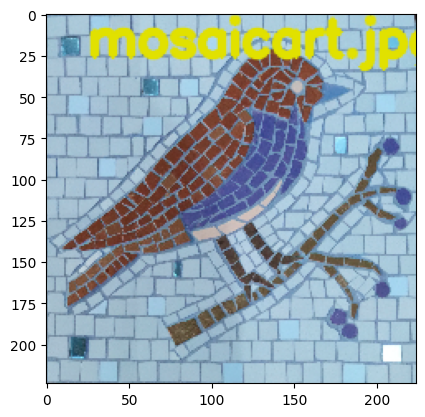

In [22]:
predict("mosaicart.jpg",transferVGG,classes)